In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
from PIL import Image
import numpy as np
import cupy as cp
import time
import scipy

from skimage.morphology import binary_dilation
from scipy.optimize import minimize

from scipy import ndimage
from scipy import interpolate

from skimage.morphology import skeletonize, opening, closing, erosion, dilation, disk
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.morphology import convex_hull_image
from skimage.restoration import inpaint
from skimage import feature

from scipy.ndimage import gaussian_filter

## GPU info

In [2]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

# HIO

In [3]:
def proj_M_gpu( x, data ):

    #'''
    fft  = cp.fft.fftn(x)
    fabs = cp.abs(fft)
    whereIszero = (fabs == 0)
    result = data * fft / fabs
    result[whereIszero] = data[whereIszero]
    result[data < 0] = fft[data < 0]
    result = cp.fft.ifftn( result )
        
    return result
    #'''

    '''
    fft    = cp.fft.fftn( x )
    phi    = cp.angle( fft )
    result = data * cp.exp(1j * phi)
    diff =  cp.abs(fft) - data
    adiff = cp.abs(diff)

    result[(data<0) | (adiff < 1)] =  fft[(data<0) | (adiff<1) ]

    tol = 1e-5 #jump@

    result[(data>=0) & (adiff >=1)] = fft[(data>=0) & (adiff>=1) ] * ( data[(data>=0) & (adiff>=1)] / ( numpy.maximum( numpy.abs(fft)[(data>=0) & (adiff>=1)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )

    result = cp.fft.ifftn( result )

    return result
    '''

    '''
    fft    = cp.fft.fftn( x )
    phi    = cp.angle(  fft  )
    result = data * cp.exp(1j * phi)

    #result[(data<0)] =  fft[(data<0)]

    #result[(data>=0)] = fft[(data>=0) ] * ( data[(data>=0)] / ( numpy.maximum( numpy.abs(fft)[(data>=0)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )

    result = cp.fft.ifftn( result )

    #result = cp.fft.ifftn(result)
    #result
    #result[ data < 0] = -1

    return result
    '''


def ref_M( x, data ):
    proj = proj_M_gpu( x, data)
    result = 2 * proj - cp.identity(x.shape[0])
    return result

def ref_S(x, supp ):
    proj = proj_S( x, supp )
    result = 2 * proj - cp.identity(x.shape[0])
    return result


def projection_M_gpu( x, data ):
    return proj_M_gpu(x, data)

def projection_S ( x, supp ):
    y = x * supp
#     y[y.real < 0] = 0.0
#     y[y.imag > 0] = 0

    real = x.real
#     real[x.real < 0] = 0.0 
    
    imag = x.imag
#     imag[imag > 0] = 0
    
    y = real + 1j*imag
    return y * supp

def projection_N ( x, supp ):
    #y = numpy.copy(x)
    #y.imag = 0
    #return y

    y    = np.copy(x.real)
    mask = (y < 0)
    y[ mask ] = 0
    return y * supp



def HIO( initial, measure, support, niterations, beta, dev, threshold):

    shrinkWrapSubIter = niterations[1]
    gniteration       = niterations[0]

    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()

    cp.cuda.Device(dev).use()

    with cp.cuda.Device(dev):

        dsupport = cp.array(support)
        smeasure = cp.array( measure )
        x        = cp.array( initial )
        csupport = cp.array( 1-support )
        xerror   = cp.array( initial )

        iteration = 0
        sigma = 6
        initialbeta = beta

        while ( iteration < gniteration ):
            
            if (iteration % 2000 == 0):
                xerror = np.copy(x)

            y = projection_M_gpu( x, smeasure )
            x = projection_S( y, dsupport ) + projection_S( x - beta * y,  1-dsupport )

            if iteration % shrinkWrapSubIter == 0 and iteration > 0:
                z = cp.array( gaussian_filter( cp.abs(x).get(), sigma) )
                dsupport = z > ( threshold/100. ) * z.max()
                sigma = 0.99 * sigma

                beta = initialbeta + (1 - initialbeta)*(1 - np.exp(-(iteration/7)**3))
                
                if (iteration > 10000):
                    x[np.abs(x) < 0.01] = 0+1j*0
                
                if (iteration > 2000):
                    real = x.real
                    real[x.real < 0] = 0.0 

                    imag = x.imag
                    imag[imag > 0] = 0.0

                    x = real + 1j*imag
            
            if (iteration % 2000 == 0 ):
                res = x.get()
                
                plt.figure(figsize = (5,5))
                plt.imshow(np.abs(res[1*res.shape[0]//3:2*res.shape[0]//3, res.shape[1]//3:2*res.shape[1]//3]))
                plt.colorbar()
                plt.show()
                
                plt.figure(figsize = (5,5))
                plt.imshow(dsupport.get())
                plt.colorbar()
                plt.show()
                
                print(iteration, np.linalg.norm(xerror -x))
                
                
            iteration += 1

    output = x.get()

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    return output



# wavefront = propagate_beam(wavefront, object_pixel_size, wavelength,+distance) # propagate
def propagate_beam(wavefront, dx, wavelength,distance,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    from cupy.fft import fft2, fftshift, ifftshift, ifft2

    ysize, xsize = wavefront.shape
    
    x_array = cp.linspace(-xsize/2,xsize/2-1,xsize)
    y_array = cp.linspace(-ysize/2,ysize/2-1,ysize)
    
    fx = x_array/(xsize)
    fy = y_array/(ysize)
    
    FX,FY = cp.meshgrid(fx,fy)

    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    elif propagator == 'fresnel':
        # % Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # % multiply by phase-shift and inverse transform 
        a = cp.exp(-1j*cp.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output


def propagation_fourier(x,inverse=False):
    if inverse == False:
        return cp.fft.fftshift(cp.fft.fft2(x))
    else:
        return cp.fft.ifft2(cp.fft.fftshift(x))
    
def projection_F_space(fft, data):
    fabs = cp.abs(fft)
    whereIszero = (fabs == 0)
    result = data * fft / fabs
    result[whereIszero] = data[whereIszero]
    result[data < 0] = fft[data < 0]
    # result = cp.fft.ifftn( result )
    return result

def get_object_pixel(N,pixel_size,wavelength,distance):
    return wavelength*distance/(N*pixel_size)

def update_wave_upstream_modulator(modulator,wave_upstream_modulator,revised_wave_downstream_modulator,wave_downstream_modulator,alpha=1):
    return wave_upstream_modulator + alpha*np.conj(modulator)*(revised_wave_downstream_modulator-wave_downstream_modulator)/np.max(np.abs(modulator)**2)

def mean_squared_error(estimate,measurement):
    return np.sum( (estimate-measurement)**2 )/(np.sum(measurement)**2)

def corrupt_data(DP, invalid_threshold=0.1, thickness = 10, gaussian_noise=(),grid_thickness=2):
    
    mask = np.ones_like(DP)
    
    if invalid_threshold > 0:
        random_matrix = np.random.rand(*DP.shape)
        random_matrix = np.where(random_matrix > invalid_threshold, 1, 0)
        mask = mask*random_matrix
    
    if thickness > 0:
        beam_stopper = np.ones_like(DP)
        beam_stopper[beam_stopper.shape[0]//2-thickness:beam_stopper.shape[0]//2+thickness,0:beam_stopper.shape[1]//2] = 0
        mask *= beam_stopper
    
    if gaussian_noise != ():
        mu, sigma = gaussian_noise
        noise = np.random.normal(mu, sigma, DP.shape) 
        DP += noise
        DP[DP<0] = -1
    
    if grid_thickness > 0:
        grid = np.ones_like(DP)
        offset = 0
        for i in range(5):
            offset += grid.shape[0]//5
            grid[offset-grid_thickness:offset+grid_thickness,:] = 0
            grid[:,offset-grid_thickness:offset+grid_thickness] = 0
        mask *= grid

    # if low_count_error: # add error of +-5 pixels for low count pixels
        
    DP[mask==0] = -1
    
    fig, ax = plt.subplots(1,2,dpi=150)
    ax[0].imshow(mask)
    ax[1].imshow(DP, norm=LogNorm())
    
    return DP

def create_image_from_text(text):
    from matplotlib.backends.backend_agg import FigureCanvas
    fig = plt.Figure(figsize=(2.56, 2.56), dpi=200)
    canvas = FigureCanvas(fig)
    ax = fig.subplots()
    t = ax.text(0.5, 0.5, text, fontsize=30, fontweight='heavy', ha='center', va='center')
    ax.axis('off')
    canvas.draw()
    img = 1- np.array(canvas.renderer.buffer_rgba())[:, :, 0]/255
    return img


def create_filter_values(initial_sigma,npoints,curvature=2, method='negative_curvature'):

    x = np.linspace(0,1,npoints)
    f1 = x
    f2 = 1-(x-1)**(2*curvature)
    f3 = x**(2*curvature)
    
    f1 = f1[::-1]
    f2 = f2[::-1]
    f3 = f3[::-1]

    # fig, ax = plt.subplots(dpi=150)
    # ax.plot(x,f1,label='x')
    # ax.plot(x,f2,label='1-(x-1)**(2*n)')
    # ax.plot(x,f3,label='x**(2*n)')
    # ax.legend()
    # ax.set_title(f'n={curvature}')

    if method == 'linear':
        return f1
    if method == 'negative_curvature':
        return f2
    elif method == 'positive_curvature':
        return f3



def shrinkwrap(img,sigma,threshold=0.5, threshold_method='max'):
    
    def gaussian_filter(img,sigma,mean=0):
        return ndimage.gaussian_filter(img, sigma)

    def apply_threshold(image,threshold,method):

        if method == 'max':
            image = np.where(image>threshold*np.max(image),1,0) 
        elif method == 'mean':
            image = np.where(image>threshold*np.mean(image),1,0) 
        elif method == 'rms':
            image = np.where(image>threshold*np.rms(image),1,0) 

        return image
    
    #TODOs:
    # - force shrinking
    # - limit number of pixels at the border to be updated
    # - set minimum fraction of pixels that support can have
    # - use range of sigma values instead of sequence from an initial value
    
    img = np.abs(img)
    
    img = gaussian_filter(img,sigma) # gaussian filter with standard deviation = sigma
    
    img = apply_threshold(img,threshold, threshold_method)
    
    return img

Detector distance = 10.00 meters
Modulator distance = 0.10 meters
Energy = 9.00 keV
FT(obj) value range = 15057.790741714973
Measurement value range = 6727.361768687077
Measurement max = 6727.423995252801 min = 0.06222656572513255   mean = 49.70666392652862
Oversampling = 5.832680669277323


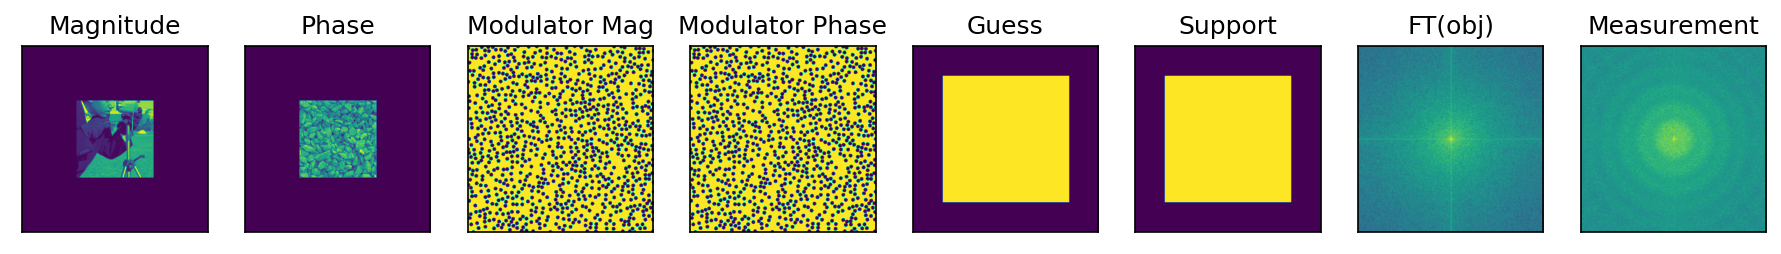

In [10]:
import random
random.seed(10)
speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]
detector_distance = 10 # meters
modulator_distance = 10e-2 # meters
energy = 9 # keV
wavelength = planck * speed_of_light / energy # meters
detector_pixel = 55e-6 # meters

print(f"Detector distance = {detector_distance:.2f} meters")
print(f"Modulator distance = {modulator_distance:.2f} meters")
print(f"Energy = {energy:.2f} keV")

path1 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/gravel512.npy'
path2 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/camera512.npy'

if 1: 
    phase = np.array( np.load(path1)) 
    magnitude = np.array( np.load(path2))
else:
    phase = create_image_from_text('CAT\nSIRIUS')
    magnitude = create_image_from_text('CAT\nSIRIUS')


n_of_pixels = magnitude.shape[0]
object_pixel_size = get_object_pixel(n_of_pixels,detector_pixel,wavelength,detector_distance)

# MODULATOR OPTIONS:
if 0: # constant magnitude, random phase
    random = np.random.rand(*magnitude.shape)
    random = scipy.ndimage.gaussian_filter(random, 2)
    modulator = 2*np.pi*(2*np.pi*random/np.max(random) - np.pi)
    modulator = 1*np.exp(1j*modulator)
else:
    # modulator = np.load('modulators/modulator_300_nm.npy')
    # modulator = np.load('modulators/modulator_100_nm.npy')
    modulator = np.load('modulators/W_modulator_300_nm_error_0_nm.npy')
    # modulator = np.load('modulators/W_modulator_300_nm_error_150_nm.npy')

if 0: # shift modulator slightly    
    modulator = np.load('modulators/W_modulator_300_nm_error_0_nm_600x600.npy')
    center = 256
    modulator2 = modulator[center-256:center+256,center-256:center+256]
    error = 30
    center += error
    print(center+256,center-256)
    shifted_modulator = modulator[center-256:center+256,center-256:center+256]
    modulator = modulator2
    
    plt.figure(dpi = 150)
    plt.imshow(np.abs(2*modulator-shifted_modulator))
        
N = 75
mask = np.zeros_like(phase)
mask[2*N:-2*N,2*N:-2*N] = 1
    
phase = phase*mask
magnitude = magnitude*mask

if 1: #loose support
    N = int(1.1*N) # 2*N = tight; 1.9 = sligtly loose
    support = np.zeros_like(phase)
    support[N:-N,N:-N] = 1
else: #tight support
    support = mask # use tight support

phase = np.pi*phase/np.max(phase)
# phase = np.ones_like(phase)
magnitude = magnitude/np.max(magnitude)
model_object = np.abs(magnitude)*np.exp(1j*phase)

wave_at_detector = np.fft.fftshift(np.fft.fftn(model_object))
measurement_without_modulator = np.abs(wave_at_detector)

model_object = propagate_beam(model_object, object_pixel_size, wavelength,modulator_distance,propagator='fresnel').get()
model_object = model_object*modulator

# plt.figure()
# plt.imshow(np.abs(model_object))
# plt.imshow(np.angle(model_object))

wave_at_detector = np.fft.fftshift(np.fft.fftn(model_object))
measurement = np.abs(wave_at_detector)

# initial_guess = np.random.rand(*magnitude.shape)
initial_guess = np.ones_like(model_object)
initial_guess = support

propagated_support = propagate_beam(support, object_pixel_size, wavelength,modulator_distance,propagator='fresnel').get()
unpropagated_support = propagate_beam(propagated_support, object_pixel_size, wavelength,-modulator_distance,propagator='fresnel').get()
propagated_support = np.abs(propagated_support)


fig, ax = plt.subplots(1,8,figsize=(15,5),dpi=150)
ax[0].imshow(magnitude), ax[0].set_title('Magnitude')
ax[1].imshow(phase), ax[1].set_title('Phase')
ax[2].imshow(np.abs(modulator)), ax[2].set_title('Modulator Mag')
ax[3].imshow(np.angle(modulator)), ax[3].set_title('Modulator Phase')
ax[4].imshow(np.abs(initial_guess)), ax[4].set_title('Guess')
ax[5].imshow(support), ax[5].set_title('Support')
ax[6].imshow(measurement_without_modulator,norm=LogNorm()), ax[6].set_title('FT(obj)')
ax[7].imshow(measurement,norm=LogNorm()), ax[7].set_title('Measurement')
# ax[4].imshow(propagated_support), ax[4].set_title('Propagation')
# ax[5].imshow(np.abs(unpropagated_support)), ax[5].set_title('UnPropagation')

for ax in ax:
    ax.set_xticks([])
    ax.set_yticks([])    
    
print(f'FT(obj) value range = {np.max(measurement_without_modulator)-np.min(measurement_without_modulator)}')
print(f'Measurement value range = {np.max(measurement)-np.min(measurement)}')
print(f'Measurement max = {np.max(measurement)} min = {np.min(measurement)}   mean = {np.mean(measurement)}')
print(f'Oversampling = {(mask.shape[0]**2)/np.sum(mask)}')

# (wavelength/10e-6)/(detector_pixel/detector_distance)

In [11]:
def CMI(initial_guess, measurement, modulator, support, iterations, pixel_size, wavelength,modulator_distance, beta=0.5, alpha=1,dev = 0,N_update=1,notCMI=False,shrink=False):

    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()

    cp.cuda.Device(dev).use()

    with cp.cuda.Device(dev):

        support     = cp.array(support)
        modulator   = cp.array(modulator)
        measurement = cp.array( measurement )
        y           = cp.array( initial_guess )
        csupport    = cp.array( 1-support )

        wave_after_support_constraint = np.ones_like(y)
 
        sigma_list = create_filter_values(5,iterations,method='linear') # sigma values for shrinkwrap gaussian filter

        iteration = 0
        plot = 100
        error = []
        while ( iteration < iterations ):
            
            if iteration < iterations*0.95:
                if iteration % plot == 0: print(f'Iteration #{iteration}: HIO')
                wave_after_support_constraint = projection_S( y, support ) + projection_S( wave_after_support_constraint - beta * y,  1-support ) 
            else:
                if iteration % plot == 0: print(f'Iteration #{iteration}: ER')
                wave_after_support_constraint = projection_S( y, support )
                
            # fig, ax = plt.subplots(1,2,dpi=150)
            # ax[0].imshow(cp.angle(wave_after_support_constraint).get())
            # ax[1].imshow(cp.abs(wave_after_support_constraint).get())
            # plt.show(), plt.close()
            
            if notCMI:
                wave_downstream_modulator = wave_after_support_constraint
            else:
                wave_upstream_modulator = propagate_beam(wave_after_support_constraint, pixel_size, wavelength,modulator_distance,propagator='fresnel')
                wave_downstream_modulator = wave_upstream_modulator*modulator
            # wave_downstream_modulator = wave_upstream_modulator

            if iteration % N_update == 0: # step IV of algorithm in the paper
                previous_wave_downstream_modulator = wave_downstream_modulator
            # previous_wave_downstream_modulator = wave_downstream_modulator

            if notCMI:
                wave_at_detector = propagation_fourier(wave_downstream_modulator)
            else:
                wave_at_detector = propagation_fourier(2*wave_downstream_modulator-previous_wave_downstream_modulator)
                    # wave_at_detector = propagation_fourier(wave_downstream_modulator)
                    
            error.append(mean_squared_error(wave_at_detector,measurement).get())
                
            projected_wave_at_detector = projection_F_space( wave_at_detector, measurement ) # different in the paper: downsampling
            
            if notCMI:
                revised_wave_downstream_modulator = propagation_fourier(projected_wave_at_detector,inverse=True)
            else:
                # revised_wave_downstream_modulator = propagation_fourier(projected_wave_at_detector,inverse=True)
                revised_wave_downstream_modulator = propagation_fourier(projected_wave_at_detector,inverse=True) - (wave_downstream_modulator - previous_wave_downstream_modulator)

            if notCMI:
                # previous_wave_downstream_modulator = wave_downstream_modulator # save for next iteration
                pass
            else:
                previous_wave_downstream_modulator = wave_downstream_modulator # save for next iteration
                revised_wave_upstream_modulator = update_wave_upstream_modulator(modulator,wave_upstream_modulator,revised_wave_downstream_modulator,wave_downstream_modulator,alpha) 

            if notCMI:
                y = revised_wave_downstream_modulator
            # y = propagate_beam(revised_wave_downstream_modulator, pixel_size, wavelength,-modulator_distance,propagator='fresnel')
            else:
                y = propagate_beam(revised_wave_upstream_modulator, pixel_size, wavelength,-modulator_distance,propagator='fresnel')
            
            sigma = 5
            if 0:#shrink:
                start_shrinkwrap = 50
                if iteration > start_shrinkwrap: 
                    # sigma = sigma_list[iteration-start_shrinkwrap]
                    # if iteration % 50 == 0: print(f'sigma = {sigma}')
                    support = shrinkwrap(y.get(),sigma,threshold=0.2)
                    support = cp.asarray(support)
            
            if iteration % plot == 0 or iteration == iterations-1:
                fig, ax = plt.subplots(1,4,figsize=(14,4))
                ax[0].imshow(cp.angle(y).get()), ax[0].set_title('Phase')
                ax[1].imshow(cp.abs(y).get()), ax[1].set_title('Magnitude')
                ax[2].imshow(np.abs(support.get())), ax[2].set_title('Support')
                ax[3].plot(error,'.-'), ax[3].set_title('Error'), ax[3].set_yscale('log')
                for ax in ax.ravel(): ax.set_xticks([]), ax.set_yticks([])
                plt.show(), plt.close()
            
            iteration += 1
            
        else:
            print("Done")
            
    output = y.get()

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    return output, support.get(), error

## CMI with good data

Iteration #0: HIO


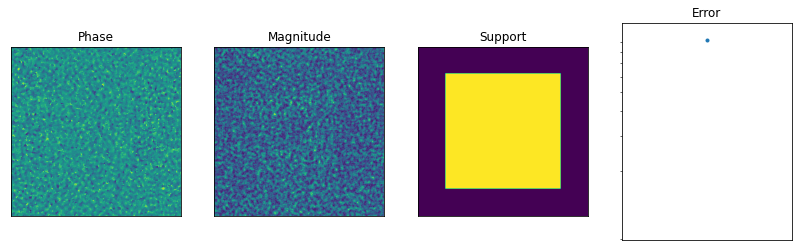

Iteration #100: HIO


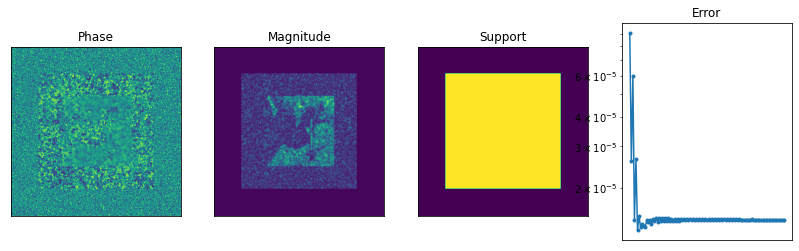

Iteration #200: HIO


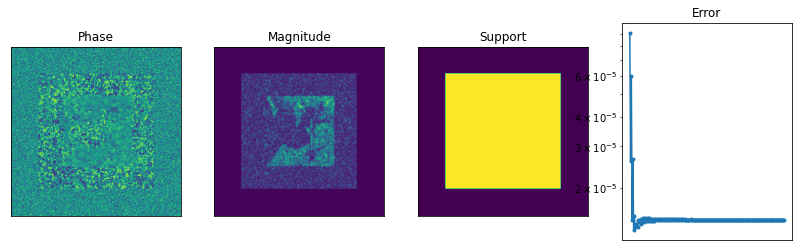

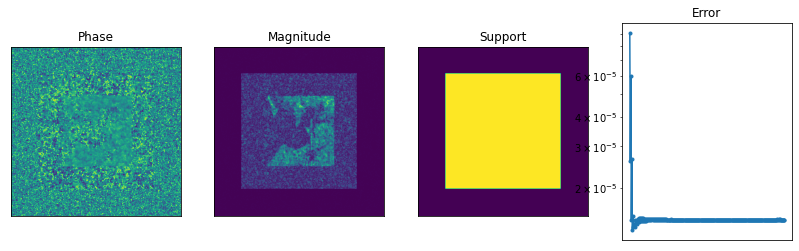

Done


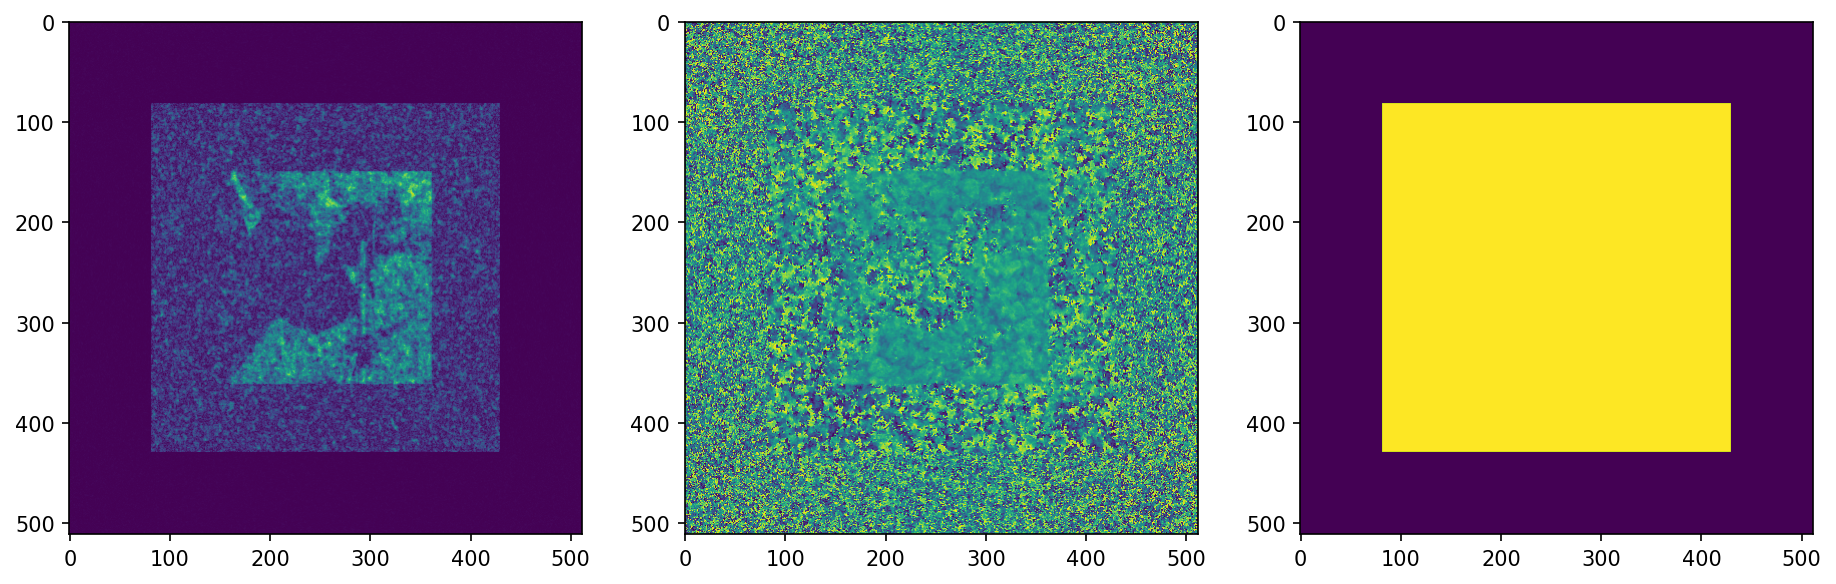

In [12]:
N_update=2
alpha = 1
beta = 1
iterations = 300
device = 0

# modulator = shifted_modulator

result, final_support, error = CMI(initial_guess, measurement, modulator, support, iterations, object_pixel_size, wavelength, modulator_distance, beta, alpha, dev = 0,N_update=N_update, notCMI=False)

fig, ax = plt.subplots(1,3,figsize=(15,5),dpi=150)
ax[0].imshow(np.abs(result))
ax[1].imshow(np.angle(result))
ax[2].imshow(np.abs(final_support))

## CMI with corrupted data

In [7]:


# corrupted_measurement = corrupt_data(measurement.copy(),invalid_threshold=0.02,thickness=0,gaussian_noise=(),grid_thickness=1)
# result, final_support, error = CMI(initial_guess, corrupted_measurement, modulator, support, iterations, object_pixel_size, wavelength, modulator_distance, beta, alpha, dev = 0,N_update=N_update, notCMI=False)

# fig, ax = plt.subplots(1,3,figsize=(15,5),dpi=150)
# ax[0].imshow(np.abs(result))
# ax[1].imshow(np.angle(result))
# ax[2].plot(error[10::],'o-'), ax[2].set_yscale('log')

## HIO with good data

Iteration #0: HIO


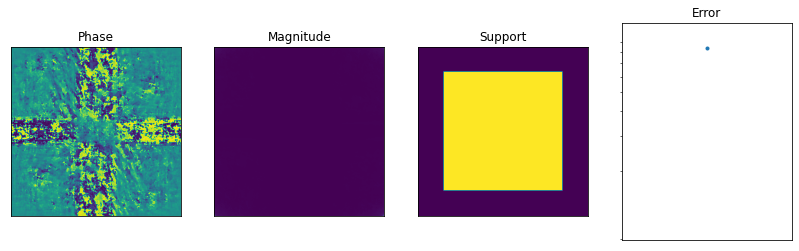

Iteration #100: HIO


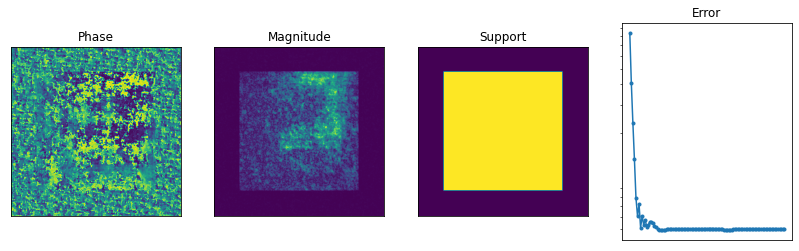

Iteration #200: HIO


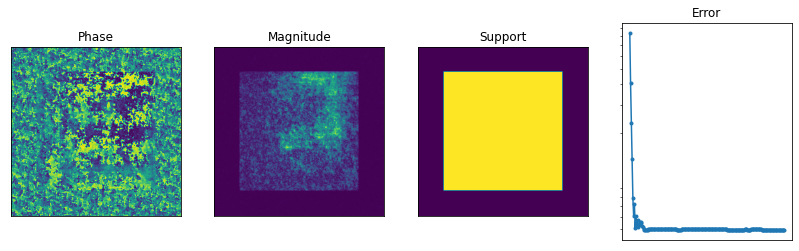

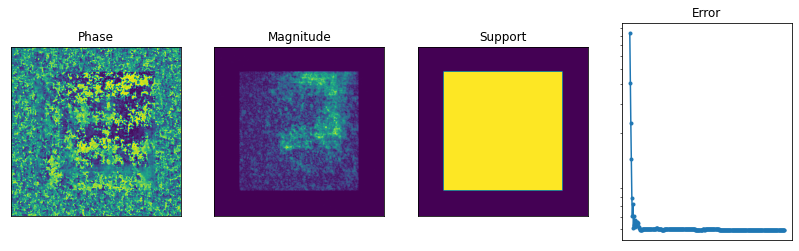

Done


([<matplotlib.lines.Line2D at 0x7f97900b75e0>], None)

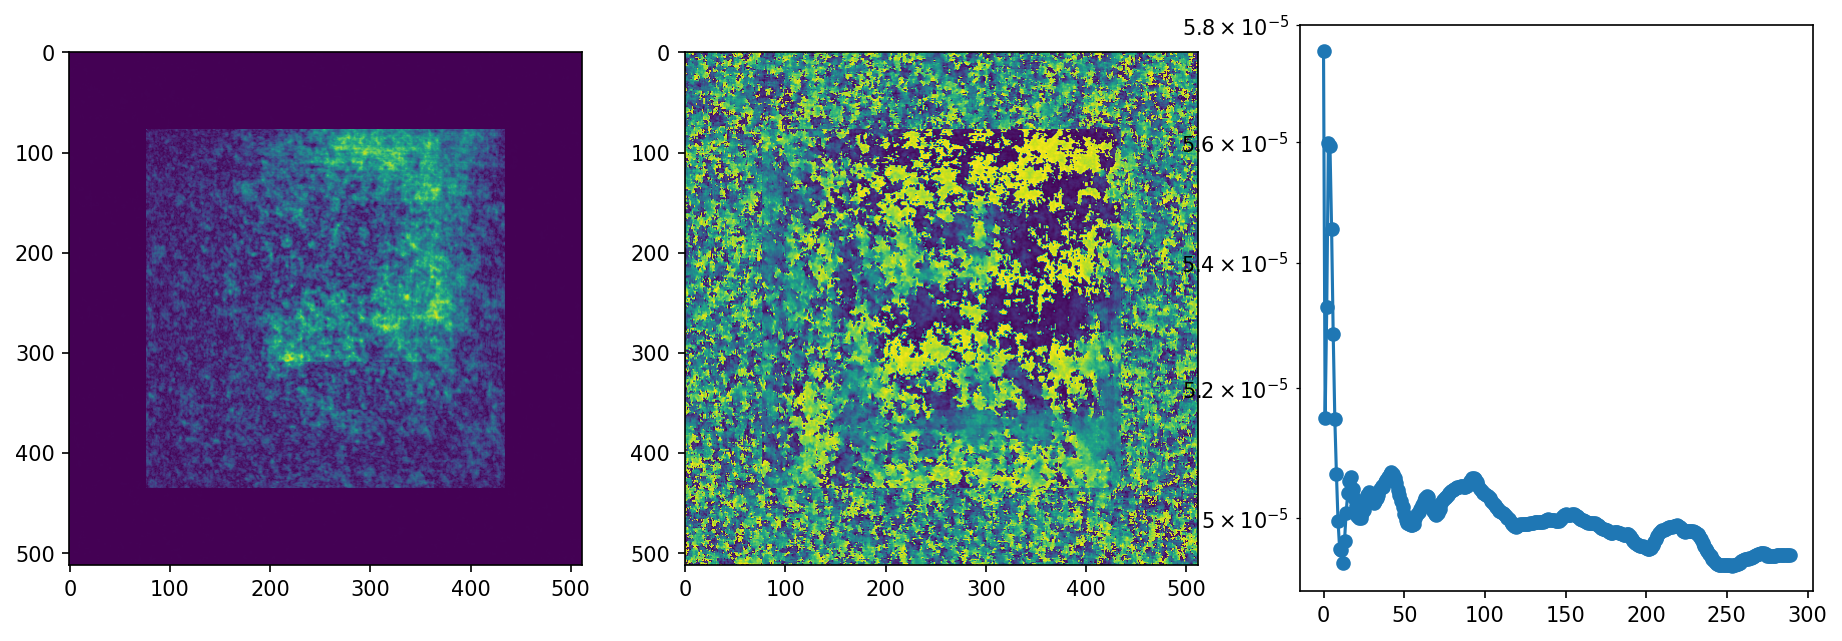

In [8]:
result, final_support, error = CMI(initial_guess, measurement_without_modulator, modulator, support, iterations, object_pixel_size, wavelength, modulator_distance, beta, alpha, dev = 0,N_update=N_update, notCMI=True)

fig, ax = plt.subplots(1,3,figsize=(15,5),dpi=150)
ax[0].imshow(np.abs(result))
ax[1].imshow(np.angle(result))
ax[2].plot(error[10::],'o-'), ax[2].set_yscale('log')

## HIO with corrupted data

In [9]:
# corrupted_measurement_without_modulator = corrupt_data(measurement_without_modulator.copy(),invalid_threshold=0.02,thickness=5,gaussian_noise=(),grid_thickness=1)
# result,final_support, error = CMI(initial_guess, corrupted_measurement_without_modulator, modulator, support, iterations, object_pixel_size, wavelength, modulator_distance, beta, alpha, dev = 0,N_update=N_update, notCMI=True)

# fig, ax = plt.subplots(1,3,figsize=(15,5),dpi=150)
# ax[0].imshow(np.abs(result))
# ax[1].imshow(np.angle(result))
# ax[2].plot(error[10::],'o-'), ax[2].set_yscale('log')